In [10]:
import numpy as np
from array import array
import pandas as pd
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import sys, yaml, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, getEff, DSetLoader

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ' '*7+'Internal'

donotdelete = []
webDir = '/storage/user/ocerri/public_html/BPH_RDst/'

In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
rt.TGaxis.SetMaxDigits(3)
expectedLumi = {'Low':6.4, 'Mid':20.7, 'High':26.4, 'Single':20.7} #fb^-1

In [3]:
binning = {'q2': array('d', [0, 3.5, 6, 9.4, 12])}
binning['M2_miss'] = [
        array('d', [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 1.5, 4] ),
        array('d', [0.0, 0.1, 0.2, 0.3] + list(np.arange(0.4, 3.5, 0.2)) + [8] ),
        array('d', list(np.arange(0, 6, 0.2)) + [8] ),
        array('d', list(np.arange(0, 7.8, 0.2)) + [8] ),
    ]
binning['Est_mu'] = [
        array('d', [0.3] + list(np.arange(0.5, 2.3, 0.05)) + [2.3] ),
        array('d', [0.3] + list(np.arange(0.5, 2.2, 0.05)) + [2.2] ),
        array('d', [0.3] + list(np.arange(0.5, 2.1, 0.05)) + [2.1] ),
        [24, 0.3, 2.0],
    ]

xAx_title = {'M2_miss':'m^{2}_{miss} [GeV^{2}]', 'Est_mu':'E_{#mu}* [GeV]'}

In [4]:
dataDir = '/storage/user/ocerri/BPhysics/data/cmsRD'

dSet = {}

for c in ['Low', 'Mid', 'High']:
    dSet[c] = {}
    
    creation_date = '201101'
    locRD = dataDir+'/skimmed/B2DstMu_B0_{}_{}'.format(creation_date, c)
    dSet[c]['data'] = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))


    creation_date = '201122'
    locRD = dataDir+'/skimmed/B2DstMu_antiB0_{}_{}'.format(creation_date, c)
    dSet[c]['antidata'] = pd.DataFrame(rtnp.root2array(locRD + '_corr.root'))

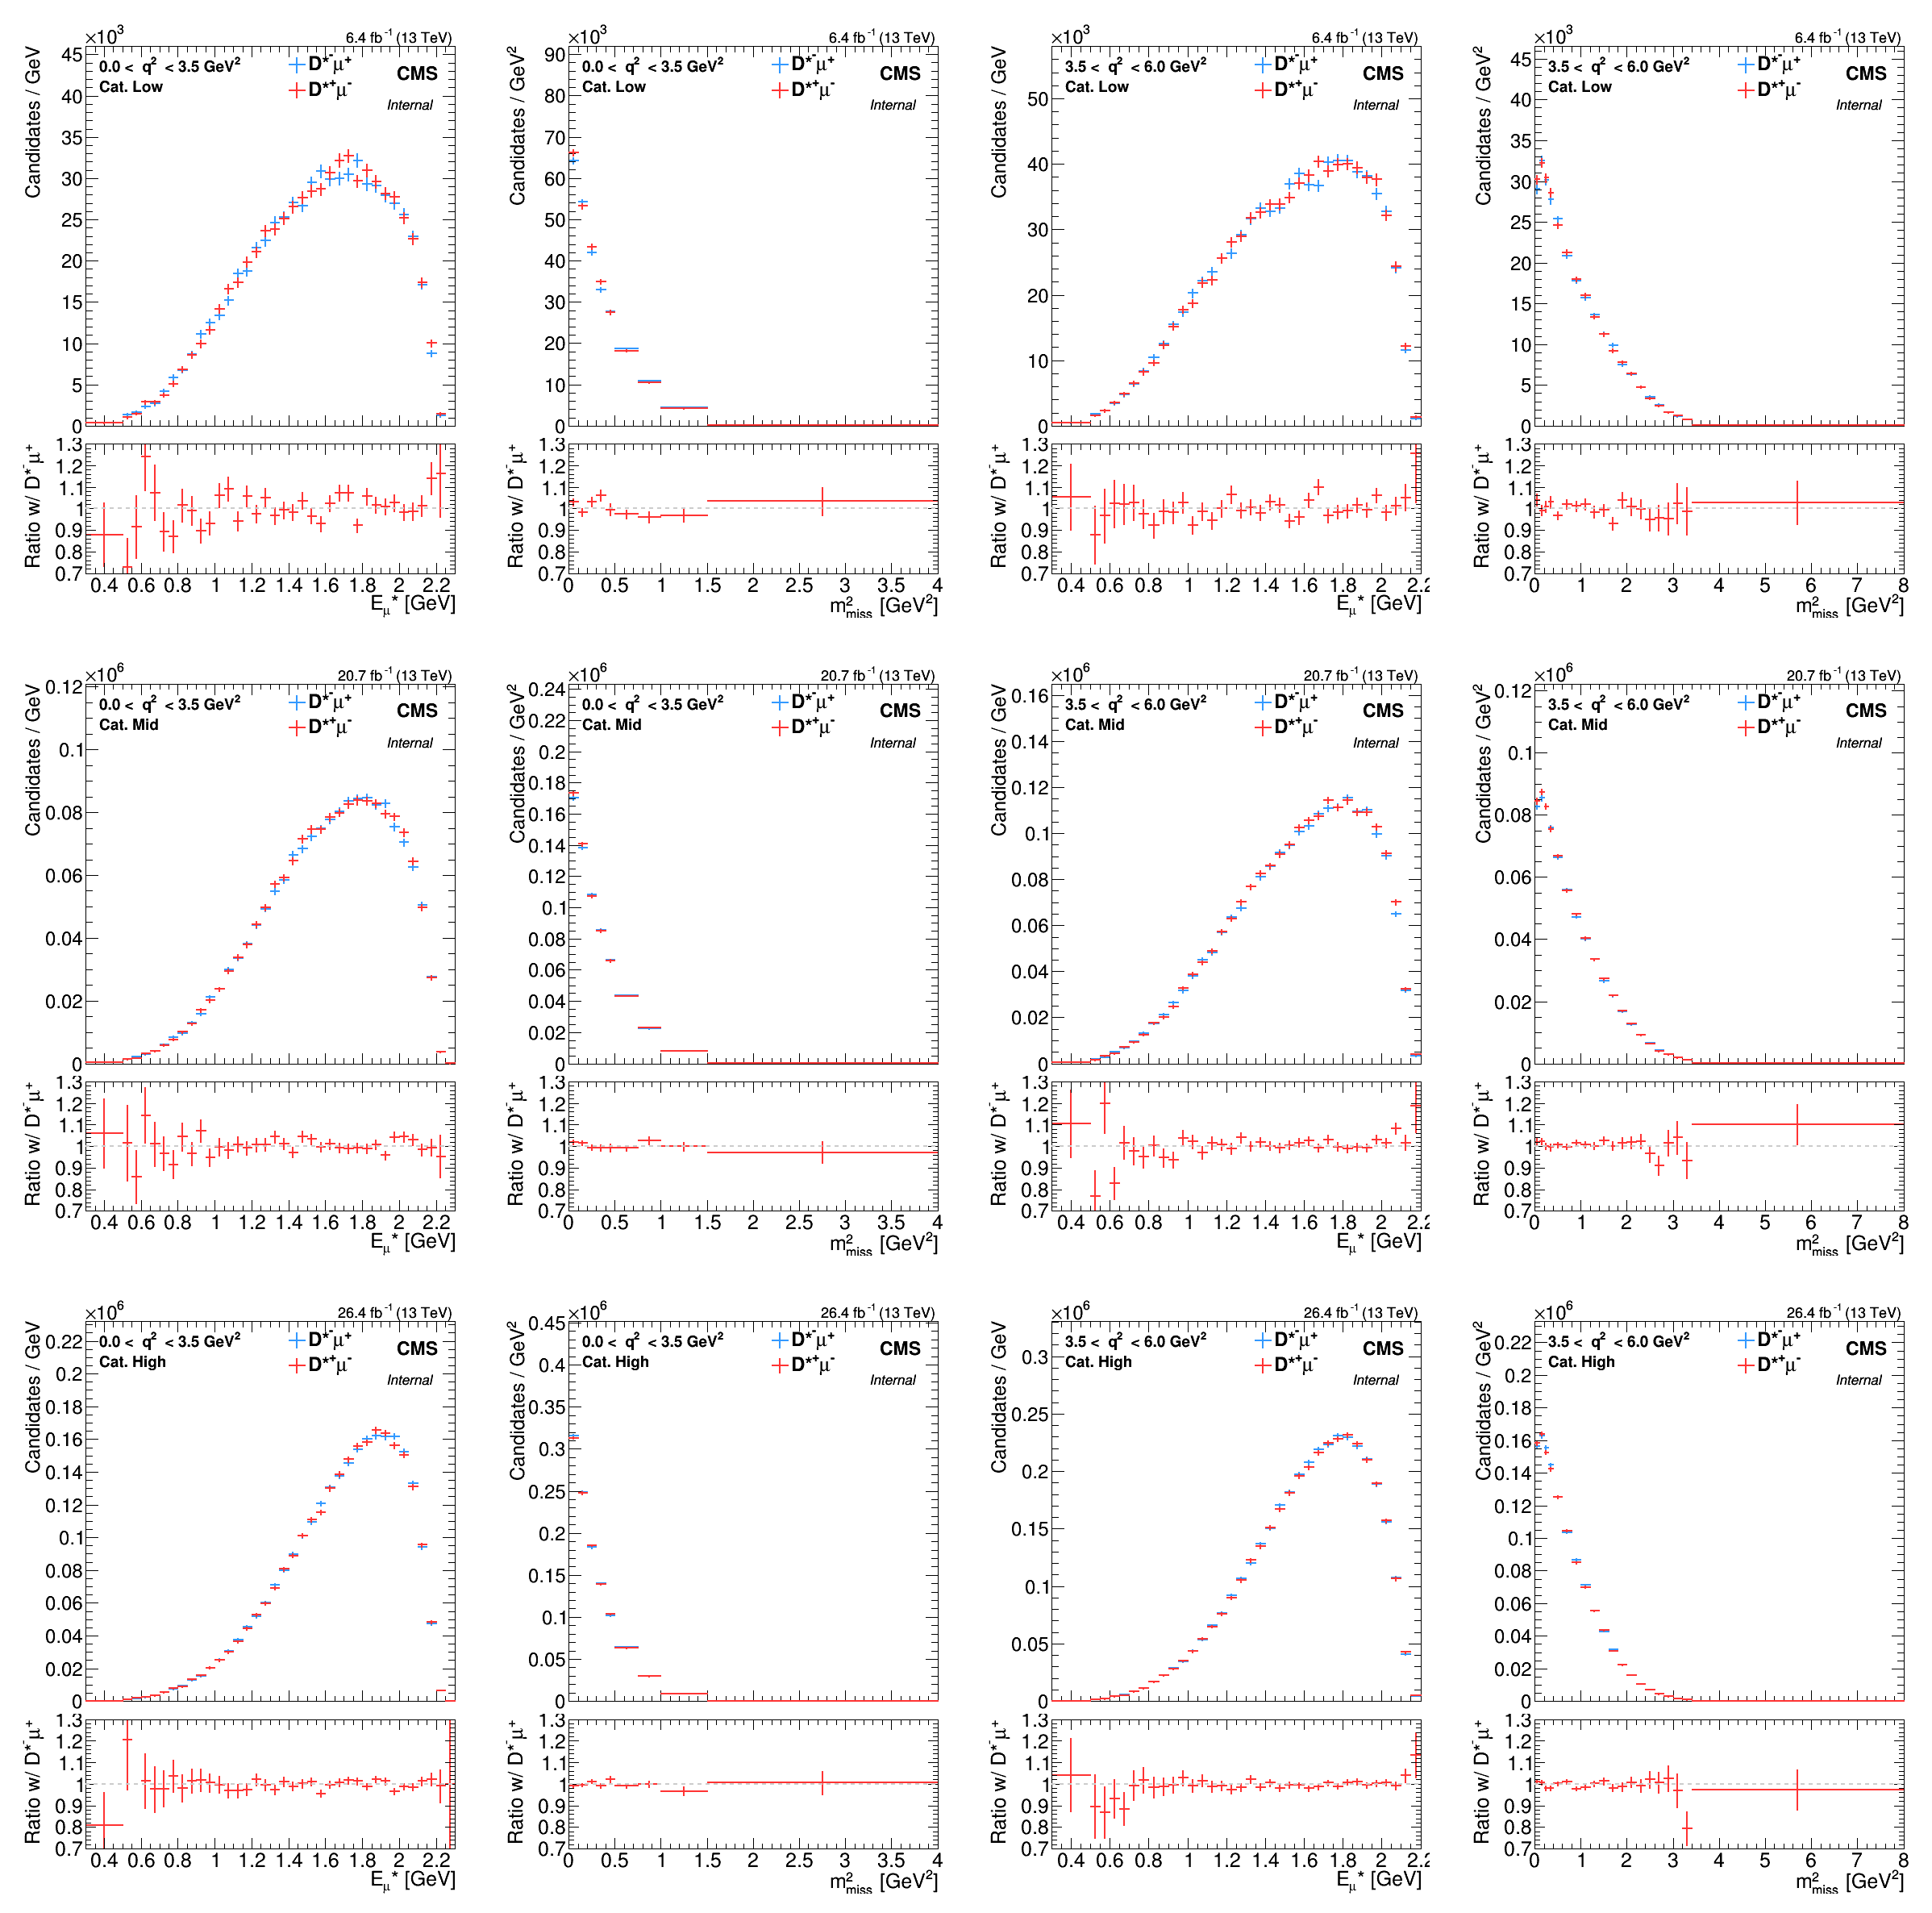

In [16]:
c_out = rt.TCanvas('cOut_'+c, 'cOut_'+c, 4*600, 3*800)
c_out.Divide(4,3)
dndLoc = []

for ic, c in enumerate(['Low', 'Mid', 'High']):
    CMS_lumi.integrated_lumi = expectedLumi[c]
    cat_txt = 'Cat. ' + c

    for iq2 in [0,1]:
        selD = np.logical_and(dSet[c]['data']['q2'] > binning['q2'][iq2], 
                              dSet[c]['data']['q2'] < binning['q2'][iq2+1])
        selA = np.logical_and(dSet[c]['antidata']['q2'] > binning['q2'][iq2], 
                              dSet[c]['antidata']['q2'] < binning['q2'][iq2+1])

        q2_l = binning['q2'][iq2]
        q2_h = binning['q2'][iq2 + 1]
        q2_txt = '{:.1f} <  q^{{2}}  < {:.1f} GeV^{{2}}'.format(q2_l, q2_h)

        for iv, var in enumerate(xAx_title.keys()):
            pad = c_out.cd(iq2*2 + iv +1 +4*ic)

            hd = create_TH1D(dSet[c]['data'][var][selD], 'hData'+c+str(iq2)+var, title='D*^{-}#mu^{+}',
                             binning=binning[var][iq2],
                             axis_title = [xAx_title[var],''],
                             widthNorm=True,
                             color=0
                            )

            iunits = xAx_title[var].find('[') + 1
            hd.GetYaxis().SetTitle('Candidates / ' + xAx_title[var][iunits:-1])

            max_y = 1.3*hd.GetMaximum()
            hd.GetYaxis().SetRangeUser(0, max_y)

            ha = create_TH1D(dSet[c]['antidata'][var][selA], 'hAntidata'+c+str(iq2)+var, title='D*^{+}#mu^{-}',
                             binning=binning[var][iq2],
                             widthNorm=True,
                             color=1
                            )

            C = make_ratio_plot([hd, ha], draw_opt='', in_pad=pad,
                                leg_pos=[0.6,0.8,0.8,0.92],
                                marginTop=0.065,
                                marginRight=0.02,
                                label = c+str(iq2)+var,
                                ratio_bounds=[0.7, 1.3])

            txt = rt.TLatex()
            txt.SetTextSize(0.04)
            txt.SetTextAlign(13)
            C.pad1.cd()
            txt.DrawLatexNDC(0.18, 0.91, '#splitline{'+q2_txt+'}{'+cat_txt+'}')
            CMS_lumi.CMS_lumi(C, -1, 33, cmsTextSize=0.75*1.2, lumiTextSize=0.6*1.2)

            C.Draw()
            dndLoc.append(C)
    c_out.Draw()
    # c_out.SaveAs(outdir+'/'+var+'.png')
    c_out.SaveAs(webDir+'/data-antidata.png')
    donotdelete.append([c_out, dndLoc])